# Reddit_assign2_ Pre-processing_Visualisation_BOW_VADER

In [1]:
# importing packages and nltk data libraries
import string
import json
import codecs
import re

import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from colorama import Fore, Back, Style
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import gensim
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lisa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lisa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# To avoid repeative writing the same code, the following will be called
%load_ext autoreload
%autoreload 1
%aimport RedditProcessing

In [3]:
# Open and read a JSON file
with open('Cleaned_VeganClimateChangeReddit.json', 'r', encoding="utf8") as file:
    redditDump = json.load(file)

# Convert list of dictionaries to DataFrame
vegan_df = pd.DataFrame(redditDump)

print(vegan_df)

                                                title                 date  \
0           Only vegans can care about climate change  2019-09-24T15:24:24   
1   Climate activists rarely suggest going vegan a...  2023-07-31T14:46:03   
2   Anyone who believes in climate change needs to...  2022-09-26T12:27:18   
3   How are all these serious climate change activ...  2023-09-13T22:49:54   
4   The way these 'climate change activists' have ...  2021-11-12T14:53:19   
5   Humans must adopt vegetarian or vegan diets to...  2019-08-06T13:27:14   
6              Still think climate change isn't real?  2023-07-25T18:23:19   
7   Biden is unveiling the Climate Corps, a jobs p...  2023-09-20T13:21:21   
8   Shoe Brand Crocs Is Officially Going Vegan to ...  2021-07-26T13:08:16   
9                       Climate change? It's handled.  2023-08-16T14:42:12   
10                        To laugh off climate change  2023-07-24T13:42:24   
11              Climate Change Denier Gets Demolished  2022-07-2

In [4]:
# check how many of posts are stored
vegan_df['title'].nunique(dropna=True)

12

In [5]:
# check again how many of posts are stored 
# if there is duplicate, it does not count
vegan_df['date'].nunique(dropna=True)

12

There is no duplicate. The data is cleaned. 

In [72]:
# Find the number of comments
no_votes = vegan_df['num_upvotes'].sum()

# Print the result
print("Number of upvotes:", no_votes, )

Number of upvotes: 269444


In [ ]:
# Find the number of comments
no_comments = vegan_df['num_comments'].sum()

# Print the result
print("Number of comments:", no_comments, )

In [7]:
# check when the posts are created
# Change 'date' is in datetime
vegan_df["date"] = pd.to_datetime(vegan_df["date"])
vegan_df["date"].min(), vegan_df["date"].max()

(Timestamp('2019-08-06 13:27:14'), Timestamp('2023-09-20 13:21:21'))

In [8]:
# Extract comments
comments = []
for post_data in redditDump:
    comments.extend(post_data.get('comments', []))

In [9]:
# Convert list of dictionaries to DataFrame
comments_df = pd.DataFrame(comments)

# check when the comments are created
# Change 'date' is in datetime
comments_df["date"] = pd.to_datetime(comments_df["date"])
comments_df["date"].min(), comments_df["date"].max()

(Timestamp('2019-08-06 14:40:00'), Timestamp('2023-09-30 03:04:49'))

In [68]:
# Find the unique number of questions
unique_comments_authors = comments_df['author'].nunique()

# Print the result
print("Unique number of comment author:", unique_comments_authors)

Unique number of comment author: 6895


## Text Pre-processing and Cleaning

In [10]:
texts = []

# find the list of texts (posts and comments)
for submission in redditDump:
    # Process the post
    postTitle = submission['title']
    texts.append(postTitle)
    postText = submission['selftext']
    texts.append(postText)

    # comments
    for comment in submission['comments']:
        commentText = comment['body']
        texts.append(commentText)

# print(texts)

If text is empty, delete.

In [11]:
texts = list(filter(lambda item: item is not None, texts))

### Convert to lowercase

In [12]:
lower = []

# convert all into lower case
for string in texts:
    lowercase = string.lower()
    lower.append(lowercase)

### Replacing URL, GIF, and image with Placeholder Token

In [13]:
import re

# Function to preprocess and tokenize text
def replacement(text):
    # Define a regular expression pattern to match URLs
    url_pattern = re.compile(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")

    # Replace strings starting with ![gif] with the placeholder
    gif_pattern = re.compile(r"!\[gif\]\([^)]+\)")

    # Define a regular expression pattern to match images
    img_pattern = re.compile(r"!\[img\]\([^)]+\)")


    # Placeholder token for URLs
    url_token = "__URL__"

    # Placeholder token for GIFs
    gif_token = "__GIF__"

    # Placeholder token for images
    img_token = "__img__"

    # Replace URLs with the placeholder token
    text_without_urls = re.sub(url_pattern, url_token, text)
    
    # Replace GIFs with the placeholder token
    text_without_gifs = re.sub(gif_pattern, gif_token, text_without_urls)
    
    # Replace images with the placeholder token
    text_without_images = re.sub(img_pattern, img_token, text_without_gifs)
    return text_without_images

In [14]:
# Apply the function to each string in the list
replaced = [replacement(s) for s in lower]

### Tokenization

In [15]:
from nltk.tokenize import word_tokenize

def tokenisation(text):
    tokens = word_tokenize(text)
    return tokens

replaced_tk = [tokenisation(word) for word in replaced]

### Stop word removal

We tried to do stemming first, but the output indicated that the word 'this' was processed as 'thi' after stemming. This occured because the Porter stemmming algorithms applies a rule to remove a plural suffix "-s," resulting in "thi.". We do like to read it as 'this', so we can remove it as one of stop words. 

Thus, we decided to do stop word removal first, and then apply stemming.

In [16]:
import string
import nltk
nltk.download('stopwords')

# use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)

# use stopwords from nltk and added 'us', and 'one'
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['us'] + ['one'] + ['via'] + ['’'] + ['...'] + ['“'] + ['”'] + ['deleted'] + ['removed'] + ['gon']+ ['na']

# remove stopwords, digits, and fractions
replaced_tk_stop = []
for tokens in replaced_tk:
    for tok in tokens:
        if tok.isalpha():
            if tok not in lStopwords:
                replaced_tk_stop.append(tok)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lisa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Stemming

In [17]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Sample text
text = ["this eat ate eaten eating"]

lTokens = [tokenisation(word) for word in text]

print(lTokens)
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Apply stemming to each word
stemmed_words = [stemmer.stem(word) for words in lTokens for word in words]

print(stemmed_words) # it processed as "thi", which is not correct

[['this', 'eat', 'ate', 'eaten', 'eating']]
['thi', 'eat', 'ate', 'eaten', 'eat']


In [18]:
from nltk.stem import PorterStemmer

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Apply stemming to each word
replaced_tk_stop_stem = []

for tok in replaced_tk_stop:
    replaced_tk_stop_stem.append(stemmer.stem(tok))
    
print(replaced_tk_stop_stem)


['vegan', 'care', 'climat', 'chang', 'mouth', 'full', 'human', 'meat', 'humanitarian', 'fair', 'vegan', 'reduc', 'amount', 'meat', 'eat', 'environment', 'impact', 'thing', 'actual', 'rest', 'lie', 'hand', 'big', 'industri', 'tri', 'realli', 'hard', 'go', 'vegetarian', 'weekday', 'meat', 'industri', 'biggest', 'pollut', 'planet', 'meat', 'eater', 'meat', 'dairi', 'industri', 'contribut', 'huge', 'amount', 'climat', 'chang', 'agre', 'gatekeep', 'told', 'shut', 'climat', 'chang', 'talk', 'main', 'point', 'made', 'solid', 'anim', 'agricultur', 'huge', 'contributor', 'climat', 'chang', 'go', 'vegan', 'easiest', 'thing', 'individu', 'make', 'posit', 'impact', 'climat', 'chang', 'vegan', 'point', 'real', 'meat', 'product', 'account', 'like', 'nation', 'green', 'hous', 'gass', 'could', 'stop', 'drive', 'today', 'meat', 'industri', 'would', 'make', 'pollut', 'point', 'mass', 'meat', 'product', 'caus', 'lot', 'deforest', 'vegan', 'eat', 'less', 'local', 'meat', 'lessen', 'consumpt', 'meat', 'yea

## Top 50 Unigram after clean

In [19]:
import sys
import json
import string
from collections import Counter
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as mpl

# number of most frequent terms to display
freqNum = 25

# our term frequency counter
termFreqCounter = Counter()

# update count
termFreqCounter.update(replaced_tk_stop_stem)

# print out most common terms
for term, count in termFreqCounter.most_common(freqNum):
    print(term + ': ' + str(count))

peopl: 2603
like: 2001
chang: 1802
climat: 1640
get: 1502
would: 1413
make: 1318
go: 1278
think: 1190
vegan: 1188
meat: 1188
thing: 1029
need: 1024
use: 1014
eat: 953
even: 951
say: 931
year: 889
know: 875
time: 838
much: 795
way: 792
anim: 774
also: 752
still: 721


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lisa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


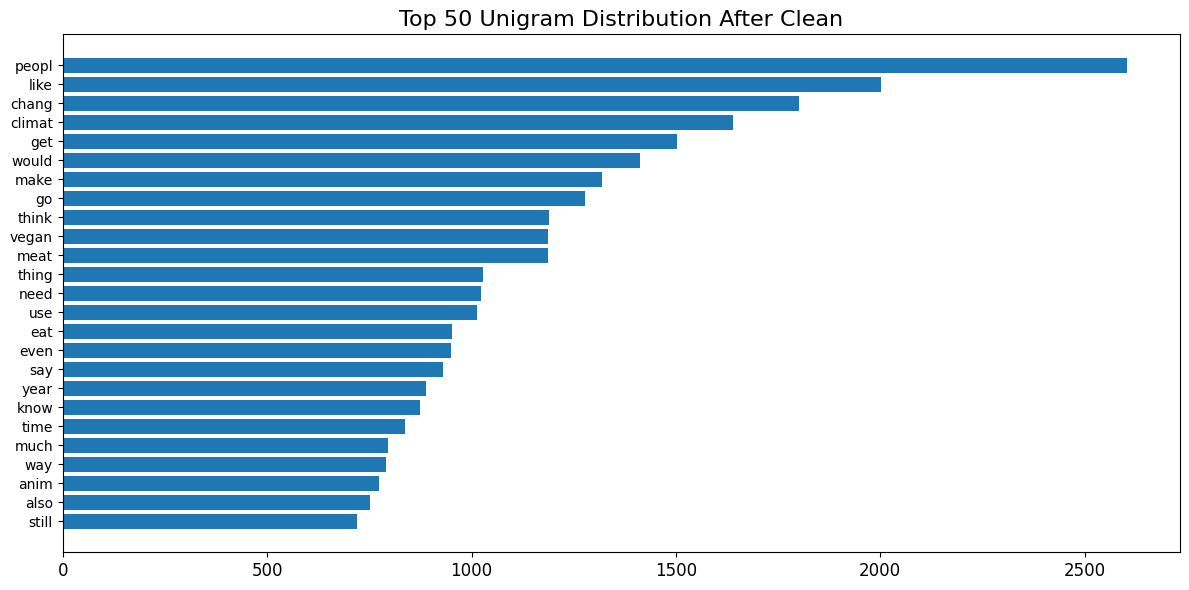

In [20]:
# Extract terms and their frequencies for plotting
terms, frequencies = zip(*termFreqCounter.most_common(freqNum))

# Plot the term frequencies
plt.figure(figsize=(12, 6))
plt.barh(terms, frequencies)
plt.title('Top 50 Unigram Distribution After Clean', fontsize=16)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

### Making Bigram

In [21]:
import nltk
from nltk.util import ngrams
from nltk.probability import FreqDist
import matplotlib.pyplot as plt            
        
# remove stop words
new_list = []
list_of_list = []
for tokens in replaced_tk:
    for tok in tokens:
        if tok.isalpha():
            if tok not in lStopwords:
                new_list.append(tok)
    list_of_list.append(new_list)
    new_list =[]
    
# Create bigrams
bigrams = []
for words in list_of_list:
    for word in range(len(words) - 1):
        bigram = (words[word], words[word + 1])
        bigrams.append(bigram)

In [22]:
# Calculate the frequency distribution of bigrams
bigram_freq = FreqDist(bigrams)

# Sort the bigrams by frequency in descending order
sorted_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

# Get the top 25 bigrams
top_25_bigrams = sorted_bigrams[:20]

# Create a DataFrame to display the top 25 bigrams
top_25_bi = pd.DataFrame(top_25_bigrams, columns=["Bigram", "Frequency"])

# Display the table of top 25 bigrams
print(top_25_bi)

                   Bigram  Frequency
0       (climate, change)       1048
1       (global, warming)        188
2           (matt, walsh)        168
3             (eat, meat)        126
4          (eating, meat)        117
5      (animal, products)        102
6            (years, ago)        102
7     (carbon, emissions)         94
8          (ozone, layer)         94
9          (people, like)         82
10         (going, vegan)         81
11         (many, people)         71
12         (plant, based)         68
13        (fossil, fuels)         65
14    (carbon, footprint)         65
15            (go, vegan)         63
16  (animal, agriculture)         62
17    (meat, consumption)         59
18         (change, real)         58
19             (ice, age)         58


In [23]:
# Convert bigrams to strings
top_25_bi['Bigram'] = top_25_bi['Bigram'].apply(lambda x: ' '.join(x))

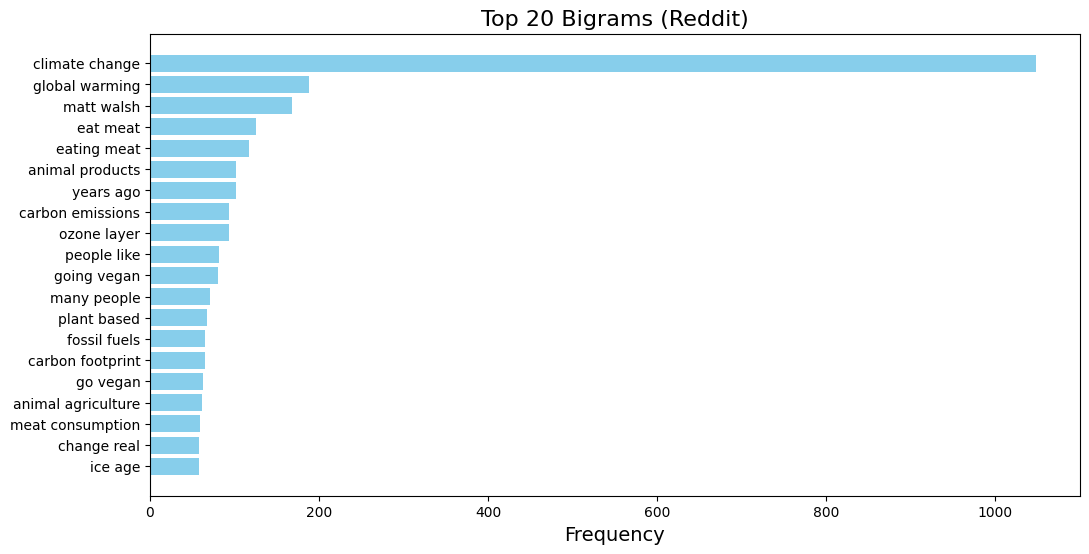

In [24]:
# Create a bar chart for the top 25 bigrams
plt.figure(figsize=(12, 6))
plt.barh(top_25_bi['Bigram'], top_25_bi['Frequency'], color='skyblue')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('')
plt.title('Top 20 Bigrams (Reddit)', fontsize=16)
plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent bigrams at the top
# Display the chart
plt.show()


## Visualisation

### Top Comment Author

Text(0.5, 1.0, 'Top 10 Most Comment Contributors')

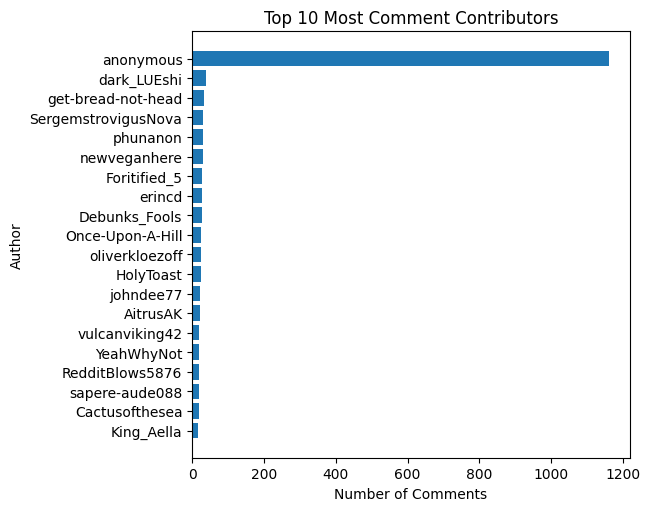

In [25]:
# Extract comments and sort them by the number of upvotes (descending order)
comments = []
for comment_data in redditDump:
    comments.extend(comment_data.get('comments', []))

# comments.sort(key=lambda x: x['num_upvotes'], reverse=True)

# None is stored as 'anonymous'
# Define the value you want to update
new_value = 'anonymous'
for comment in comments:
    if comment['author'] == None:
        comment['author'] = new_value

# create a list of author        
author = []        
for comment in comments:
    author.append(comment['author'])
    
# Create a Pandas DataFrame
top_contributors = pd.DataFrame({'Value': author})

# Count the frequency of each value and get the top 10 most frequent values
top_10_author = top_contributors['Value'].value_counts().head(20)

# Create a bar plot for the top 10 most frequent values
plt.barh(top_10_author.index, top_10_author.values)
# plt.xticks(rotation=70)
plt.gca().invert_yaxis()
# plt.xticks(fontsize=12)
plt.tight_layout()
plt.xlabel('Number of Comments')
plt.ylabel('Author')
plt.title('Top 10 Most Comment Contributors')

Text(0.5, 1.0, 'No. of Comments by Author (Reddit)')

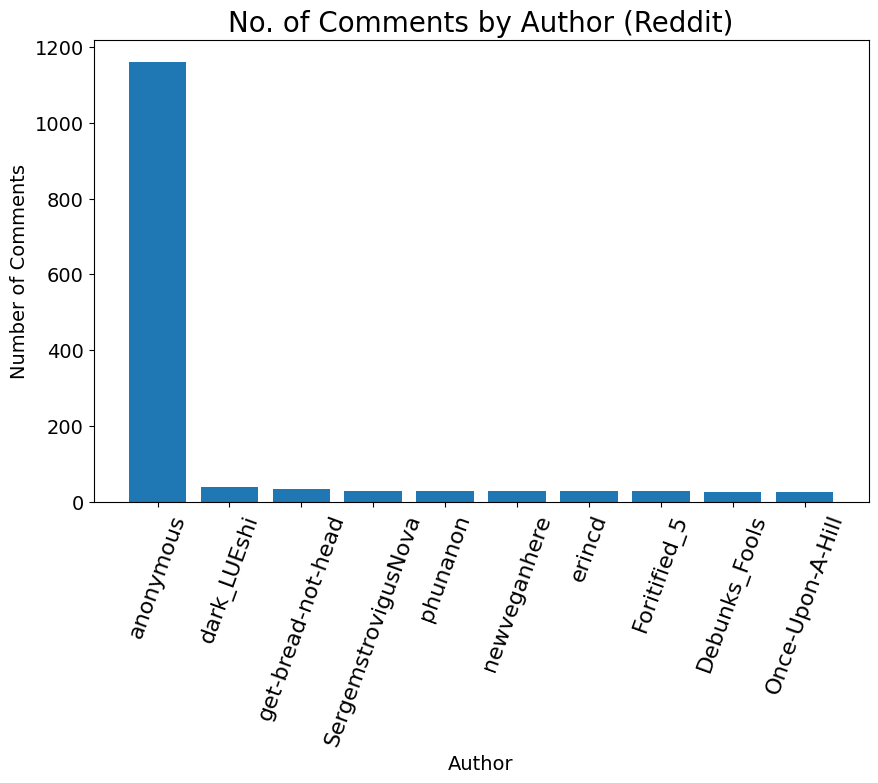

In [79]:
# Extract comments and sort them by the number of upvotes (descending order)
comments = []
for comment_data in redditDump:
    comments.extend(comment_data.get('comments', []))

comments.sort(key=lambda x: x['num_upvotes'], reverse=True)

# None is stored as 'anonymous'
# Define the value you want to update
new_value = 'anonymous'
for comment in comments:
    if comment['author'] == None:
        comment['author'] = new_value

# create a list of author        
author = []        
for comment in comments:
    author.append(comment['author'])
    
# Create a Pandas DataFrame
top_contributors = pd.DataFrame({'Value': author})

# Count the frequency of each value and get the top 10 most frequent values
top_10_author = top_contributors['Value'].value_counts().head(10)

# Create a bar plot for the top 10 most frequent
plt.figure(figsize=(10, 6))
plt.bar(top_10_author.index, top_10_author.values)
plt.yticks(fontsize=14)
plt.xticks(rotation=70, fontsize=16)
plt.xlabel('Author', fontsize=14)
plt.ylabel('Number of Comments', fontsize=14)
plt.title('No. of Comments by Author (Reddit)', fontsize=20)

In [66]:
print(top_10_author)

Value
anonymous              1161
dark_LUEshi              38
get-bread-not-head       33
SergemstrovigusNova      29
phunanon                 29
newveganhere             29
erincd                   28
Foritified_5             28
Debunks_Fools            27
Once-Upon-A-Hill         26
Name: count, dtype: int64


Text(0.5, 1.0, 'No. of Comments by Author except for Anonymous (Reddit)')

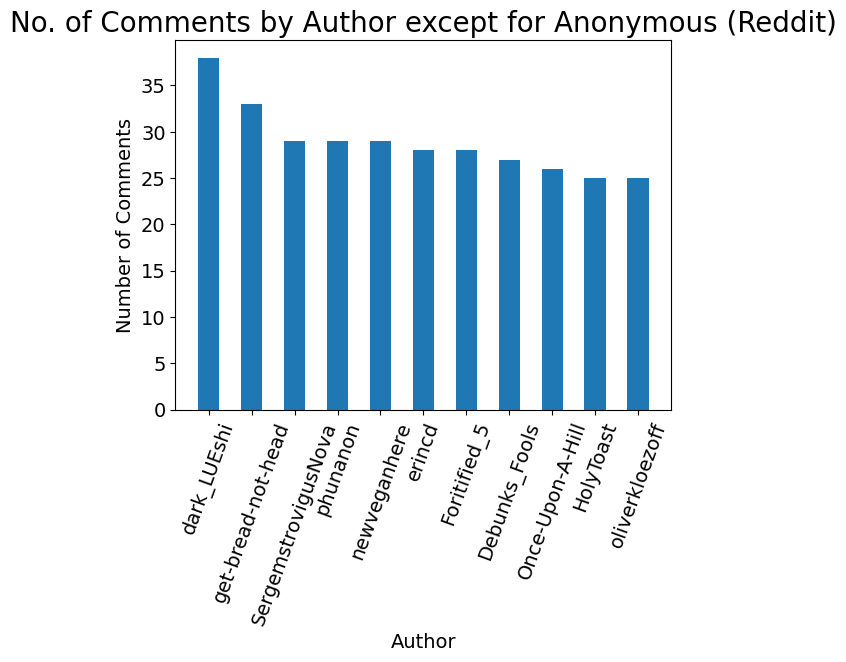

In [81]:
# Count the frequency of each value
value_counts = top_contributors['Value'].value_counts()

# Get the top 11 most frequent values (excluding the most frequent, anonymous)
top_11_frequent = value_counts.iloc[1:12]

# Create a bar plot for the top 2nd to 11th most frequent values
plt.bar(top_11_frequent.index, top_11_frequent.values, width=0.5)
plt.xticks(rotation=70, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Author', fontsize=14)
plt.ylabel('Number of Comments', fontsize=14)
plt.title('No. of Comments by Author except for Anonymous (Reddit)', fontsize=20)

Text(0.5, 1.0, 'No. of Comments by Author except for Anonymous (Reddit)')

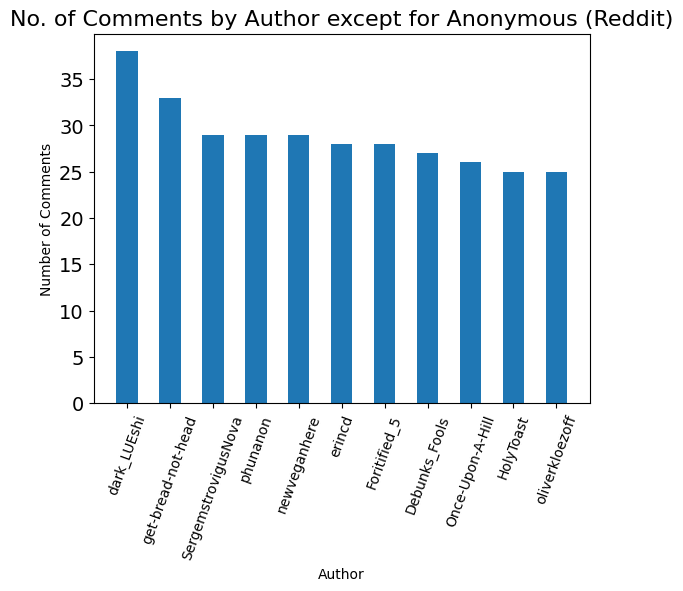

In [82]:
# Count the frequency of each value
value_counts = top_contributors['Value'].value_counts()

# Get the top 11 most frequent values (excluding the most frequent, anonymous)
top_11_frequent = value_counts.iloc[1:12]

# Create a bar plot for the top 2nd to 11th most frequent values
plt.bar(top_11_frequent.index, top_11_frequent.values, width=0.5)
plt.xticks(rotation=70)
plt.yticks(fontsize=14)
plt.xlabel('Author')
plt.ylabel('Number of Comments')
plt.title('No. of Comments by Author except for Anonymous (Reddit)', fontsize=16)

### Timeseries of Number of comments - NOT SURE IF NEED

In [28]:
comments.sort(key=lambda x: x['num_upvotes'], reverse=True)

# Select the top 1000 comments with the most upvotes
top_1000_comments = comments[:1000]
top_comments_df = pd.DataFrame(top_1000_comments)

# Change 'created_date' is in datetime
top_comments_df["date"] = pd.to_datetime(top_comments_df["date"])
top_comments_df["date"].min(), top_comments_df["date"].max()

(Timestamp('2019-08-06 14:40:00'), Timestamp('2023-09-21 09:24:22'))

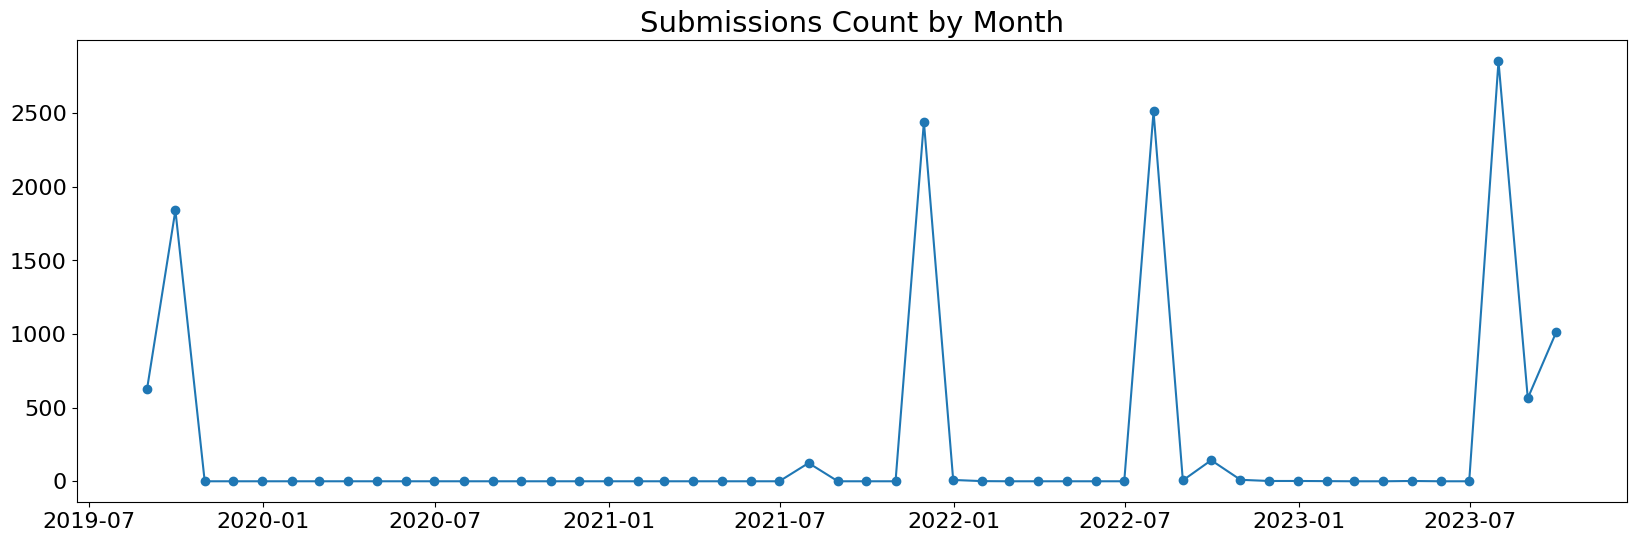

In [29]:
comments_df = pd.DataFrame(comments)

# Change 'created_date' is in datetime
comments_df["date"] = pd.to_datetime(comments_df["date"])

# Group submissions by day and count them
daily_counts = comments_df.resample('M', on='date').size()

# Adjust the width to make the bars thicker
bar_width = 3

# Create the time series plot
plt.figure(figsize=(20, 6))
plt.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-')
# plt.bar(daily_counts.index, daily_counts.values, color='b', width=bar_width)
plt.title('Submissions Count by Month', fontsize=21)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

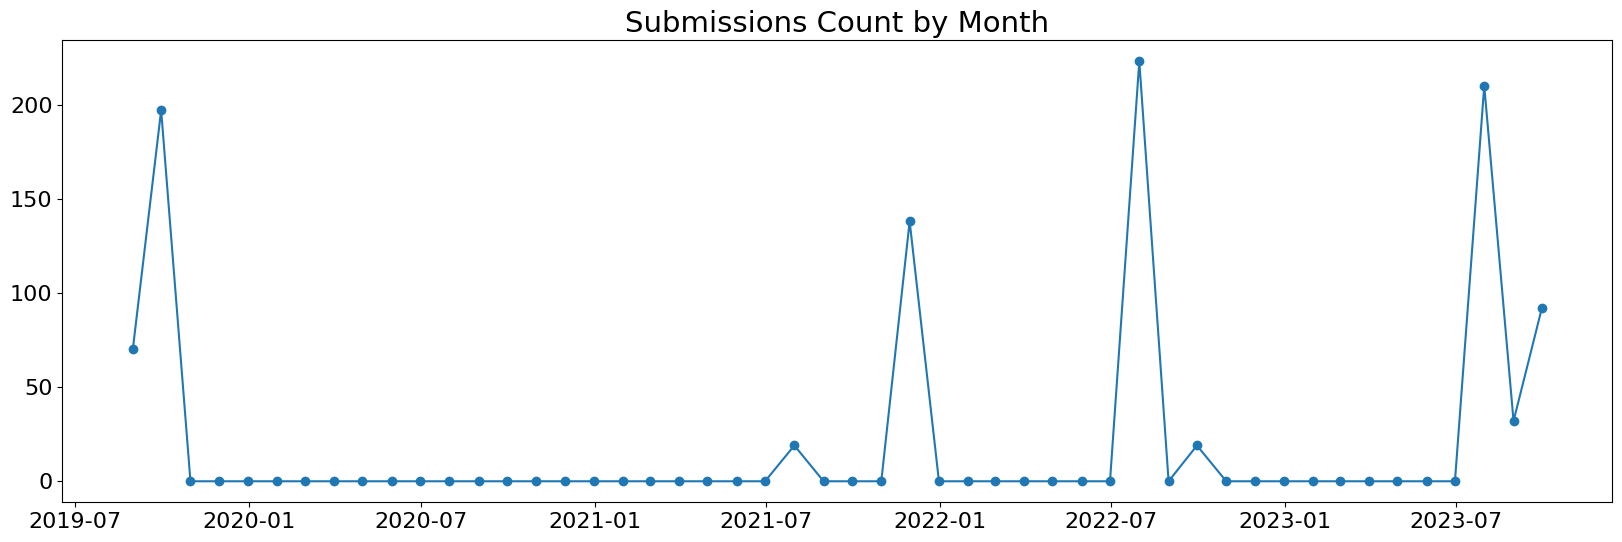

In [30]:
# Group submissions by day and count them
daily_counts = top_comments_df.resample('M', on='date').size()

# Adjust the width to make the bars thicker
bar_width = 3

# Create the time series plot
plt.figure(figsize=(20, 6))
plt.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-')
# plt.bar(daily_counts.index, daily_counts.values, color='b', width=bar_width)
plt.title('Submissions Count by Month', fontsize=21)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

### Relationship between Number of Comments and Score - NOT SURE IF NEED

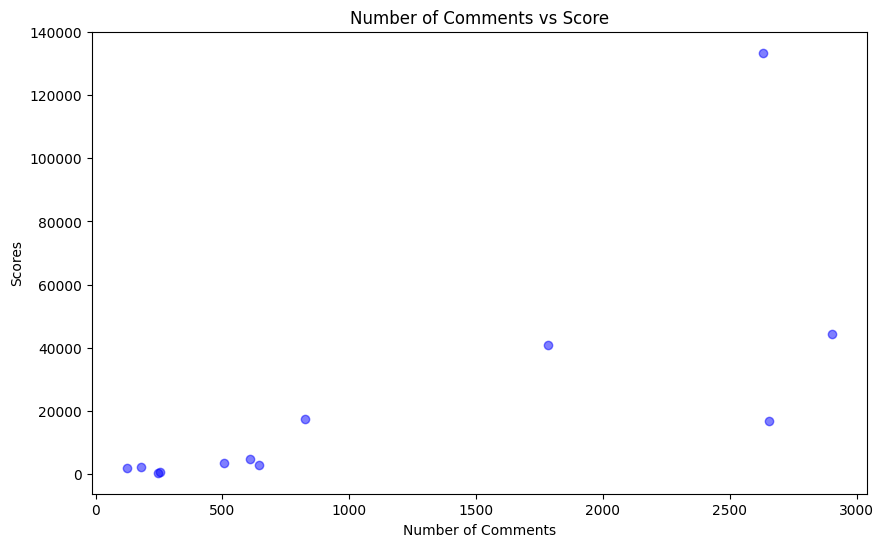

In [31]:
# # Extract sentiment scores and number of upvotes for the selected comments
num_comments = list(vegan_df['num_comments'])
post_scores = list(vegan_df['score'])

# Create a scatter plot of sentiment scores vs. number of upvotes
plt.figure(figsize=(10, 6))
plt.scatter(num_comments, post_scores, color='blue', alpha=0.5)
plt.xlabel('Number of Comments')
plt.ylabel('Scores')
plt.title('Number of Comments vs Score')
# plt.grid(True)
plt.show()

## Analysis Approach

## Sentiment Analysis

## Bag Of Word (Count) Method
Use counts of positive and negative words to calculate the sentiment.

In [32]:
def check_word_in_file(word, file):
    with open(file, 'r') as file:
        # Tokenize the text into words
        content = file.read().split()
        if word in content:
            return True
    return False

In [33]:
def computeSentiment(lTokens, setPosWords, setNegWords):
    """
    Compute the overall sentiment of the list of tokens in lTokens, using the countWordSentimentAnalysis approach.
    
    @param lTokens: List of tokens to calculate the overall sentiment for.
    @param setPosWords: Set of positive words.
    @param setNegWords: Set of negative words.
    
    @returns Sentiment score for lTokens.
    """

    posNum = len([tok for tok in lTokens if tok in setPosWords])

    negNum = len([tok for tok in lTokens if tok in setNegWords])

    sentiment = posNum - negNum
    
    return sentiment

In [34]:
def printColouredTokens(lTokens, setPosWords, setNegWords, sentiment):
    """
    Print out the tokens in different colours, according to sentiment.
    If positive, in red.
    If negative, in blue.
    Otherwise no colouring.
    
    @param lTokens: List of tokens to print and colour.
    @param setPosWords: Set of positive words.
    @param setNegWords: Set of negative words.
    @param sentiment: Sentiment score of list of tokens.
    """


    for tok in lTokens:
        if check_word_in_file(tok, setPosWords):
            print(Fore.RED + tok + ', ', end='')
        elif check_word_in_file(tok, setNegWords):            
            print(Fore.BLUE + tok + ', ', end='')
        else:
            print(Style.RESET_ALL + tok + ', ', end='')
    print(': {}'.format(sentiment))
    

In [35]:
def countWordSentimentAnalysis(text, setPosWords, setNegWords, Filename, redditProcessor):
    """
    Basic sentiment analysis.  Count the number of positive words, count the negative words, overall polarity is the
    difference in the two numbers.

    @param setPosWords: set of positive sentiment words
    @param setNegWords: set of negative sentiment words
    @param sFilename: name of input file containing a json formated dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param redditProcessor: RedditProcessing object, used to pre-process each tweet.

    @returns: list of reddit posts, in the format of [date, sentiment]
    """
    lTokens = redditProcessor.process(text)
    sentiment = computeSentiment(lTokens, setPosWords, setNegWords)
    
    # if we are printing, each token is printed and coloured according to red if positive word, and blue
    # if negative
#     if bPrint:
#         printColouredTokens(lTokens, setPosWords, setNegWords, sentiment)
    
    return sentiment

In [36]:
# input file of set of postive words
posWordFile = 'positive-words.txt'
# input file of set of negative words
negWordFile = 'negative-words.txt'
# input file of set of reddit posts (json format)
redditFile = 'Cleaned_VeganClimateChangeReddit.json'
# flag to determine whether to print out tweets and their sentiment
flagPrint = True
# specify the approach to take, one of [count, vader]
# change this to use a different sentiment approach
approach = 'count'

In [37]:
# construct the reddit pro-processing object
# use tweet tokenizer
tweetTokenizer = TweetTokenizer()

lPunct = list(string.punctuation)   

# use standard 'English' stopwords plus we want to remove things like'would', 'us', and 'one'
lStopword = nltk.corpus.stopwords.words('english') + lPunct + ['would', 'us', 'one','...', '…', '"', "'", '`', 'deleted', 'removed', 'gon', 'na']

# call the RedditProcessing python script
redditProcessor = RedditProcessing.RedditProcessing(lStopword)

# load set of positive words
lPosWords = []
with open(posWordFile, 'r', encoding='utf-8', errors='ignore') as fPos:
    for sLine in fPos:
        lPosWords.append(sLine.strip())

setPosWords = set(lPosWords)


# load set of negative words
lNegWords = []
with codecs.open(negWordFile, 'r', encoding='utf-8', errors='ignore') as fNeg:
    for sLine in fNeg:
        lNegWords.append(sLine.strip())

setNegWords = set(lNegWords)

In [38]:
# Iterate through the comments and add sentiment score to each comment
for post_data in redditDump:
    for comment in post_data.get('comments', []):
        comment_text = comment['body']
        comment_sentiment = countWordSentimentAnalysis(comment_text, setPosWords, setNegWords, redditFile, redditProcessor)
        comment['sentiment_score'] = comment_sentiment

# Save the updated JSON data to a new file
with open('BOW_sentiment_per_comment.json', 'w', encoding='utf-8') as output_json_file:
    json.dump(redditDump, output_json_file, ensure_ascii=False, indent=4)

In [39]:
# Load your JSON data from the file
with open('BOW_sentiment_per_comment.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# Extract comments and sort them by the number of upvotes (descending order)
comments = []
for post_data in data:
    comments.extend(post_data.get('comments', []))

comments.sort(key=lambda x: x['num_upvotes'], reverse=True)

# Select the top 100 comments with the most upvotes
top_100_comments = comments[:100]

# Extract sentiment scores and comment text for the selected comments
sentiment_scores = [comment['sentiment_score'] for comment in top_100_comments]
comment_texts = [comment['body'] for comment in top_100_comments]

for comment in comment_texts:
    lTokens = redditProcessor.process(comment)
    sentiment = computeSentiment(lTokens, posWordFile, negWordFile)
    printColouredTokens(lTokens, posWordFile, negWordFile, sentiment)

fucking, hate, paradox, fixing, problem, makes, people, think, need, fix, problem, never, got, bad, enough, affect, successful, prevention, makes, seem, uninformed, never, needed, : 0
remember, big, issue, got, fixed, talked, anymore, curious, sooner, later, gunna, run, bullshit, right, surely, much, stupid, shit, generate, doesnt, anyone, talk, black, death, anymore, curious, went, away, explain, libs, weird, polio, stopped, talked, vaccine, cause, memory, loss, : 0
honey, call, police, : 0
funny, thing, tire, get, replaced, thrown, dump, lay, couple, thousand, years, slowly, decomposing, carbon, dioxide, atmosphere, : 0
point, mass, meat, production, causes, lot, deforestation, vegan, eat, less, local, meat, : 0
: 0
stand, water, pee, creates, cold, spot, : 0
mouth, full, human, meat, humanitarian, : 0
murdering, cuts, carbon, emissions, : 0
glasgow, climate, change, conference, vehicles, tires, deflated, : 0
murder, kids, : 0
vegan, point, real, meat, production, accounts, like, nat

oxygen, woke, owns, libs, need, : 0
literally, theocratic, fascist, bio, ca, tell, put, take, piss, criticizers, actually, signal, genuine, beliefs, bet, ambiguity, wants, though, : 0
bother, getting, vaccine, polio, smallpox, measles, even, gets, diseases, anymore, : 0
tack, chemicals, waste, pumped, environment, including, methane, gas, agriculture, responsible, world, release, greenhouse, gases, : 0
thanos, approach, global, climate, change, : 0
told, shut, climate, change, talking, damn, stealing, : 0
greenhouse, gas, emissions, according, un, : 0
idea, info, soon, since, announced, yeah, go, need, someone, positive, enthusiastic, bro, : 1
woke, mother, nature, ron, suing, soon, enough, worry, : 0
fema, probably, pick, tab, happening, vermont, fema, picking, tab, people, flood, insurance, zone, : 0
needs, least, three, times, bigger, blank, spaces, counterpoints, : 0
socialism, benefits, american, christian, loves, god, trump, : 0
sartre, quote, never, believe, completely, unaware,

In [40]:
# Display the top 100 comments and their sentiment scores
for i, (score, text) in enumerate(zip(sentiment_scores, comment_texts), start=1):
    print(f"Comment {i} (Sentiment Score: {score}):")
    print(text)
    print("-" * 50)

Comment 1 (Sentiment Score: -4):
I fucking hate the paradox where fixing a problem makes people think you didn't need to fix the problem because it never got bad enough to affect them. Successful prevention makes it seem, to the uninformed, that it was never needed.
--------------------------------------------------
Comment 2 (Sentiment Score: -6):
"Remember that one big issue that got fixed and no one talked about it anymore? Curious isn't it?"

Sooner or later they're gunna have to run out of bullshit, right? Surely there's only so much stupid shit they can generate.

"WHY DOESNT ANYONE TALK ABOUT THE BLACK DEATH ANYMORE? CURIOUS HOW IT JUST WENT AWAY. EXPLAIN THAT, LIBS?"

"WEIRD HOW POLIO STOPPED BEING TALKED ABOUT AFTER THE VACCINE. DID IT CAUSE MEMORY LOSS?"
--------------------------------------------------
Comment 3 (Sentiment Score: 0):
“Honey, call the police”
--------------------------------------------------
Comment 4 (Sentiment Score: -3):
Funny thing is that tire will get

### Count total number of Positive, Negative, and Neutral Sentiment (Count)

In [41]:
# Define a function to add the 'status' column based on the 'temperature'
def add_sentiment_count(sentiment):
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [42]:
# Iterate through the comments and add sentiment score to each comment
for post_data in redditDump:
    for comment in post_data.get('comments', []):
        comment_text = comment['body']
        comment_sentiment = countWordSentimentAnalysis(comment_text, setPosWords, setNegWords, redditFile, redditProcessor)
        comment_sentiment_class = add_sentiment_count(comment_sentiment)
        comment['sentiment_class'] = comment_sentiment_class

# Save the updated JSON data to a new file
with open('BOW_sentiment_per_comment_Classified.json', 'w', encoding='utf-8') as output_json_file:
    json.dump(redditDump, output_json_file, ensure_ascii=False, indent=4)

In [43]:
# Load your JSON data from the file
with open('BOW_sentiment_per_comment_Classified.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# Extract comments and sort them by the number of upvotes (descending order)
comments = []
for post_data in data:
    comments.extend(post_data.get('comments', []))

# comments.sort(key=lambda x: x['num_upvotes'], reverse=True)

# Select the top 100 comments with the most upvotes
# top_100_comments = comments[:100]

# Extract sentiment scores and comment text for the selected comments
sentiment_class = [comment['sentiment_class'] for comment in comments]

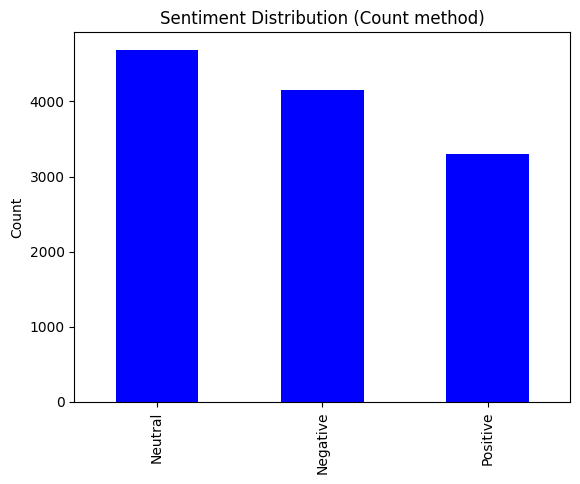

In [44]:
# Create a Pandas Series to count the occurrences of each class
sentiment_counts = pd.Series(sentiment_class).value_counts()

# Plot the class counts as a bar chart
sentiment_counts.plot(kind='bar', color='blue')

# Add labels and title
plt.xlabel('')
plt.ylabel('Count')
plt.title('Sentiment Distribution (Count method)')

# Display the plot
plt.show()

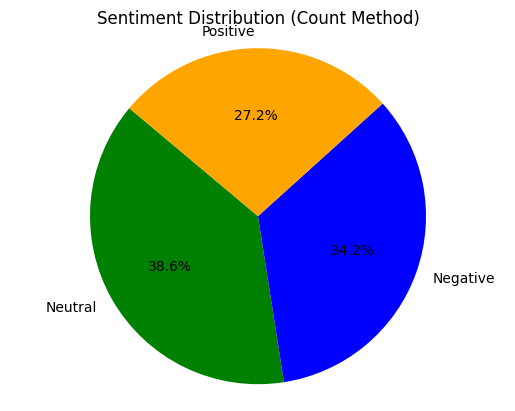

In [45]:
import matplotlib.pyplot as plt

# Sample data
labels = ['Neutral', 'Negative', 'Positive']
sizes = [4688, 4158, 3305]  # Sizes or proportions for each category
colors = ['green', 'blue', 'orange']  # Colors for each category

# Create a pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Sentiment Distribution (Count Method)')

# Display the chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

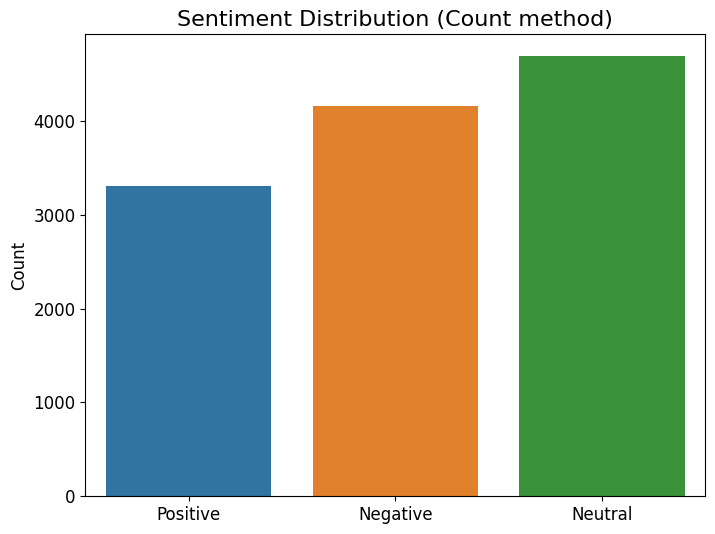

In [46]:
# Example DataFrame
reorder_data = {
    'Category': ['Neutral', 'Negative', 'Positive'],
    'Value': [4688, 4158, 3305],
}

reorder_df = pd.DataFrame(reorder_data)

# Define the custom order for the bars
custom_order = ['Positive', 'Negative', 'Neutral']

# Create a bar chart with the custom order using Seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.barplot(x='Category', y='Value', data=reorder_df, order=custom_order)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('')
plt.ylabel('Count', fontsize = 12)
plt.title('Sentiment Distribution (Count method)', fontsize= 16)
plt.show()


## Vader based approach

In [47]:
def vaderPrintTokens(lTokens, dSentimentScores):
    """
    Print out the tokens and sentiment score.
    
    @param lTokens: List of tokens to print and colour.
    @dSentimentScores: Dictionary of sentiment from Vader.

    """
    print(*lTokens, sep=', ')
    for cat,score in dSentimentScores.items():
        print('{0}: {1}, '.format(cat, score), end='')
    print()

In [48]:
def vaderSentimentAnalysis(Filename, bPrint, Processor):
    # this is the vader sentiment analyser, part of nltk
    sentAnalyser = SentimentIntensityAnalyzer()

    lSentiment = []
    with open(Filename, 'r', encoding='utf-8') as f:
        redditDump = json.load(f)

        for submission in redditDump:
            # Process the comments
            for comment in submission['comments']:
                commentText = comment['body']
                commentDate = comment['date']

                # pre-process the reddit post text
                lTokens = redditProcessor.process(commentText)

                # Compute the sentiment scores using Vader
                dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

                # Store the sentiment score as a key in the comment
                comment['sentiment_score'] = dSentimentScores['compound']
                
                # if we are printing, we print the tokens then the sentiment scores.  Because we don't have the list
                # of positive and negative words, we cannot use colorama to label each token
                if bPrint:
                    vaderPrintTokens(lTokens, dSentimentScores)    

    return redditDump


In [49]:
# input file of set of postive words
posWordFile = 'positive-words.txt'
# input file of set of negative words
negWordFile = 'negative-words.txt'
# input file of set of reddit posts (json format)
redditFile = 'Cleaned_VeganClimateChangeReddit.json'
# flag to determine whether to print out tweets and their sentiment
flagPrint = True
# specify the approach to take, one of [count, vader]
# change this to use a different sentiment approach
approach = 'vader'

In [50]:
# compute the sentiment
# to change method, update parameter settings, particularly the variable 'approach' and rerun the parameter setting cell,
# and also this cell
lSentiment = []
if approach == 'count':
    lSentiment = countWordSentimentAnalysis(posWordFile, negWordFile, redditFile, flagPrint, redditProcessor)
elif approach == 'vader':
    lSentiment = vaderSentimentAnalysis(redditFile, flagPrint, redditProcessor)

mouth, full, human, meat, humanitarian
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fair, vegan, reducing, amount, meat, eat, environmentally, impactful, things, actually, rest, lies, hands, big, industry, trying, really, hard, go, vegetarian, weekdays, meat, industry, biggest, polluters, planet
neg: 0.236, neu: 0.692, pos: 0.072, compound: -0.6361, 
meat, eater, meat, dairy, industry, contribute, huge, amount, climate, change
neg: 0.0, neu: 0.796, pos: 0.204, compound: 0.3182, 
agree, gatekeeping, told, shut, climate, change, talking, main, point, made, solid, animal, agriculture, huge, contributor, climate, change, going, vegan, easiest, thing, individual, make, positive, impact, climate, change
neg: 0.0, neu: 0.632, pos: 0.368, compound: 0.8957, 
vegan, point, real, meat, production, accounts, like, nations, green, house, gasses, could, stop, driving, today, meat, industry, make, pollution
neg: 0.101, neu: 0.783, pos: 0.115, compound: 0.0772, 
point, mass, meat, production, causes,

much, pollution, producing, fertilizer, otherwise, going, sourced, fossil, fuels, though, turning, fossil, fuels, fertilizer, releases, carbon, burning, animals, fed, fertilized, crops, releasing, absorbed, atmosphere, first, place
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
point, real, overarching, problem, person, holding, sign, probably, sees, issues, almond, milk
neg: 0.197, neu: 0.803, pos: 0.0, compound: -0.4019, 
yea, point, stops, real, know, exactly, meat, even, name, chicken, lays, eggs, shit, mass, meat, production, shit, maybe, instead, giving, people, shit, eating, meat, maybe, give, people, shit, urge, eat, burgers, eat, thing, fucking, disgusting, boat, kind, people
neg: 0.353, neu: 0.538, pos: 0.109, compound: -0.9278, 
point, real, counterproductive, better, people, eating, meat, give, shit, climate, change, people, obviously, good, people, stop, eating, meat, approach, work, well
neg: 0.195, neu: 0.539, pos: 0.266, compound: 0.2732, 
tack, chemicals, waste, pumped,

generally, people, actually, picketing, dont, think, far, people, spreading, pictures, stories, trying, push, climate, change, whole, chances, everyone, holding, signs, personally, sharing, pictures, like, want, change, happen, recognize, danger, doesnt, lead, fight, people, agree, instead, people, dont
neg: 0.073, neu: 0.645, pos: 0.281, compound: 0.7707, 
divisive, side, issue, brilliant, advocacy, strategy, actually, dividing, subcauses, something, try, accomplish, side, issue, personally
neg: 0.0, neu: 0.663, pos: 0.337, compound: 0.765, 
well, defeats, point, going, vegan, helps, fight, climate, change, people, could, go, vegan, today, climate, change, affected, hell, probably, vegans, change, anything
neg: 0.349, neu: 0.503, pos: 0.148, compound: -0.7506, 
acres, forage, per, head, cattle, acre, cattle, know, fucking, crazy, sounds, used, cars, acres, previously, owned, cars, choose
neg: 0.137, neu: 0.863, pos: 0.0, compound: -0.4005, 
yeah, also, graze, plants, vegan, diet, soyb

like, humans, manage, adapt, forcing, try, new, foods, half, refuse, eat, trying, point, guessing, ethical, issues, arent, concerns, imagine, find, technology, communicate, animals, far, fetched, know, imagine, trying, explain, want, pay, someone, open, throats, like, taste, flesh, crispy, cooked, certain, way, imagine, telling, mother, forcibly, impregnated, want, drink, milk, made, baby, dont, like, milks, involvement, victim, connecting, food, helps, lot, understand, ethical, issues, arent, everyone, though
neg: 0.07, neu: 0.666, pos: 0.264, compound: 0.9287, 
case, agree, agree, tone, shaming, people, shutting, conversation, productive, think, important, message, communicate, way, people, may, respond, think, likelier, push, people, away, fair, point, veganism, comes, lot, personal, thinking, means, joining, unpopular, often, ridiculed, group, always, okay, bash, inconvenience, etc, agree, things, things, necessarily, care, stake, might, make, harder, go, vegan, definitely, things,

aware, wary, tactic, even, op, posted, vegan, subreddits, much, appreciation
neg: 0.0, neu: 0.732, pos: 0.268, compound: 0.5106, 
feel, majority, steadfast, viewpoint, like, give, leeway, civility, overtly, terroristic, minority, important, viewpoints, qualms, called, example, something, mild, domestic, look, upon, tactics, op, say, strong, opinions, mean, strongly, dictating, people, lifestyle, culture, small, thing
neg: 0.098, neu: 0.636, pos: 0.266, compound: 0.6597, 
nah, make, assumptions, judge, regardless, make, despite, context, clues, happy, call, people, cunts, moment, someone, calls, strangely, hostile, hella, projecting, cringey, e, cause, got, locked, go, subs, get, mad, people, subs, say, trying, get, little, angry, rocks, dude, least, little
neg: 0.376, neu: 0.624, pos: 0.0, compound: -0.9539, 
sorry, watched, matrix
neg: 0.394, neu: 0.606, pos: 0.0, compound: -0.0772, 
week, heatwave, kills, live, months, year, killing, heat
neg: 0.568, neu: 0.432, pos: 0.0, compound: -

ever, assumed, ignorance, part, example, food, waste, planned, obsolescence, far, detrimental, planet, eating, meat, commercial, farming, practice, cover, crops, example, also, far, detrimental, agriculture, meat, industry, slowly, degrades, soil, quality, make, unusable, growing, healthy, crops, inflating, cons, meat, industry, forgetting, bunch, things, far, detrimental, planet, something, actually, healthy, source, food
neg: 0.141, neu: 0.739, pos: 0.119, compound: -0.3182, 
reality, grow, enough, plant, proteins, feed, entire, population, earth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
want, post, climate, activism, simply, fuel, posting, goal, posting, metric, engagement
neg: 0.0, neu: 0.677, pos: 0.323, compound: 0.5106, 
almost, every, leftist, person, becomes, rather, hypocritical, bring, veganism
neg: 0.273, neu: 0.727, pos: 0.0, compound: -0.4588, 
see, climate, change, make, vegan, definitely, go, plant, based, movement, cli

easier, time, getting, people, drive, electric, cars, getting, give, meat, india, country, functionally, vegan, generations, constantly, increasing, meat, consumption, really, worth, energy, change, population, zero, interest, even, considering, hell, even, pushing, tried, going, day, without, meat, met, laughter
neg: 0.146, neu: 0.645, pos: 0.209, compound: 0.2831, 
recruited, donating, national, sea, rescue, month, activist, talked, super, surprised, asked, could, save, fish, eating, fish
neg: 0.0, neu: 0.494, pos: 0.506, compound: 0.9062, 
called, cognitive, dissonance
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
vegans, revolutionaries, climate, change, wo, addressed, properly, capitalism
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
going, vegan, moral, decision, based, avoiding, animal, suffering, avoiding, delaying, climate, change, let, explain, environmental, activist, objective, people, carry, activities, pollute, case, automobile, emissions, example, using, public, transpor

lmfao, get, rekt, suv, driver, obviously, optics, bad, sure, convict, someone, wantonly, destroyed, personal, trucks, people, drive, trucks, need, worst
neg: 0.342, neu: 0.475, pos: 0.184, compound: -0.7184, 
convinced, op, cia, admitted, years, ago, infiltrate, groups, like, like, peta, link, solutions, climate, change, annoying, shit, like, general, population, agree, idea, disrupt, global, economy, hegemony, big, agricultural, automotive, businesses, reason, mossad, intelligence, agencies
neg: 0.128, neu: 0.488, pos: 0.384, compound: 0.8625, 
vandalism, figure, sue, money, least, america
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
likely, pretending
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.1027, 
anything, help, climate
neg: 0.0, neu: 0.426, pos: 0.574, compound: 0.4019, 
people, buying, suv, also, piece, shit
neg: 0.419, neu: 0.581, pos: 0.0, compound: -0.5574, 
perfect, reason, anyone, drive, gas, guzzling, vehicles, like, people, need, take, action, hope, start, seeing, ar

dumbshits, ca, even, spell, tires, right, bruh
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
touch, paper, make, sure, cops, able, get, finger, prints
neg: 0.0, neu: 0.777, pos: 0.223, compound: 0.3182, 
drive, flat, get, worse, gas, mileage, show
neg: 0.341, neu: 0.659, pos: 0.0, compound: -0.4767, 
love, idiotic, thinkers, like, disabled, suv, bigger, diesel, guzzling, vehicle, take, place, remove, also, actively, contributed, creation, disposal, toxic, material, may, never, existed, kept, sweaty, dirty, hippy, hands
neg: 0.164, neu: 0.556, pos: 0.28, compound: 0.5574, 
mom, simple, woman, straight, point, always, said, want, people, side, best, way, achieve, make, feel, welcome, like, enemy
neg: 0.123, neu: 0.423, pos: 0.454, compound: 0.8126, 
well, either, die, together, stop, driving, fucking, suv
neg: 0.462, neu: 0.379, pos: 0.159, compound: -0.6124, 
defund, regulate, military, corrupt, largest, producers, emissions, everything, reducing, carbon, footprint, recycling, largely, 

sure, climate, activist, really, met, enough, know, know, shit, better, target, corporate, pollution, environmental, regulations, lack, thereof, possible, middle, schoolers, understand, climate, change, flyer, look, like, work, middle, schoolers, either, put, money, climate, denier, trying, manufacture, outrage, towards, activists
neg: 0.228, neu: 0.623, pos: 0.15, compound: -0.6124, 
even, know, two, photos, actually, related
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
assuming, awd, option, pay, follow, guideline, base, model, fwd, crossover, base, model, rwd, suv, another, clue, suvs, body, frame, crossovers, unibody
neg: 0.065, neu: 0.935, pos: 0.0, compound: -0.1027, 
look, first, useful, commenter, thread
neg: 0.0, neu: 0.58, pos: 0.42, compound: 0.4404, 
glasgow, public, transport, get, stabbed
neg: 0.42, neu: 0.58, pos: 0.0, compound: -0.4404, 
vehicles, road, permanently, nowhere, even, close, amount, energy, savings, come, removing, gene, pool
neg: 0.0, neu: 0.851, pos: 0.1

doubt, comfortably, fit, suv, either, honest, certainly, better, something, like, mondeo, example, may, shock, generally, really, space, suv, may, look, like, really, gaining, ride, height, bigger, body, interior, space, look, nissan, juke, looks, huge, outside, bigger, inside, golf, comically, small, boot, suv, really, granted, exceptions, high, riding, hatchback, based, really, want, extra, space, teenagers, dog, much, better, served, buying, estate, car
neg: 0.061, neu: 0.565, pos: 0.374, compound: 0.9719, 
prime, example, someone, incapable, making, valid, argument
neg: 0.505, neu: 0.495, pos: 0.0, compound: -0.6249, 
wait
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ah, reddit, let, punish, random, person, driving, car
neg: 0.327, neu: 0.673, pos: 0.0, compound: -0.5267, 
inconvenienced, someone, destroyed, property, foolish, idyllic, beliefs, literal, level, harm, good, way, around
neg: 0.425, neu: 0.435, pos: 0.14, compound: -0.7096, 
also, think, electricity, made, power, cars

ok, cool, long, realize, inconsistencies
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.5423, 
saltwater, shrimp, dumped, freshwater, lake, lmao, fell, propaganda
neg: 0.346, neu: 0.368, pos: 0.287, compound: 0.0516, 
find, source, shrimp, please, wait, need, eat, cows, people, thing, call, plant, based, even, better, vegan, eat, flesh, another, animals, pleasure, unnecessary, kill, cow, food, suffering, needles, along, health, environmental, benefits, plant, based, diet, really, best, choices, peta, eat, dogs, euthanise, woul, ok, kill, animal, long, eat
neg: 0.182, neu: 0.553, pos: 0.265, compound: 0.5709, 
peta, stealing, people, pets, peta, property, logic, fine, claiming, peta, stealing, pets, important, question, whether, peta, steals, people, pets, actually, statement, bears, relationship, reality, saw, two, things, two, times, formed, really, strong, opinion, based, basically, nothing, happens, lot, people, lot, things, argument, peta, like, times, lmao, peta, actually, really, bad,

option, dont, really, care, trying, tightly, regulate, lives, make, room, billion, people, billion, people, get, whatever, want, sounds, better
neg: 0.123, neu: 0.694, pos: 0.182, compound: 0.0913, 
dick, wed, clean, even, land, growing, food, still
neg: 0.26, neu: 0.394, pos: 0.346, compound: 0.0258, 
humans, capability, stop, climate, change
neg: 0.355, neu: 0.645, pos: 0.0, compound: -0.296, 
go, response, ahem, u
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
rather, watch, world, burn, humans, go, back, abysmal, state, existing, eat, nothing, vegan, bullshit, diet, vegies, anyway, want, burger, im, get, fckng, burger
neg: 0.0, neu: 0.828, pos: 0.172, compound: 0.5223, 
never, happen, ever, entire, lifestyles, thousands, years, culture, built, around, animal, husbandry, might, well, tell, people, give, religion, people, kill, people, less, given, fact, billion, people, convert, matter, decades, never, happened, purporting, veganism, solution, climate, change, wholly, irresponsible, 

unfortunately, rural, scotland, biggest, thing, miss
neg: 0.5, neu: 0.5, pos: 0.0, compound: -0.4588, 
still, learning, recipes, hoping, switch, entirely, eventually
neg: 0.0, neu: 0.682, pos: 0.318, compound: 0.4215, 
trying, incorporate, set, back, freak, accident, accidentally, ate, whole, load, uncooked, ones, kinda, hurts, think, eating
neg: 0.483, neu: 0.517, pos: 0.0, compound: -0.8809, 
yeah, think, going, cut, fish, first, meat, like, least, fishing, nets, really, bad, well, trying, substitute, meat, lately, probably, wo, able, go, full, vegan, goal, get, close, vegetarian, possible, thanks, encouragement
neg: 0.138, neu: 0.562, pos: 0.299, compound: 0.7082, 
adequately, healthy, proved, endlessly, said, veganism, actually, healthier, still, true, touting, veganism, health, benefits, snake, oil, tastes, fine, prove, wrong, good, luck, trying, refute, subjective, descriptor, behaviour, changes, easily, outpace, population, growth, blatantly, claim, people, fighting, killing, re

climate, always, changing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, every, summer, depends, weather, patterns, happens, cooler, next, year
neg: 0.0, neu: 0.783, pos: 0.217, compound: 0.3612, 
never, denied, climate, change, real, reverse, ice, age, guess, means, climate, change, happening, throughout, history, die, life, take, maybe, someday, species, nothing, like, evolve, nurture, earth, looks, like, bunch, people, returning, north, east, due, mild, weather, climate, change, bought, region, according, activist, kid, hole, ozone, killed
neg: 0.257, neu: 0.701, pos: 0.042, compound: -0.9052, 
hotter, dust, bowl, times, remember, school, saving, rainforests, poof, nobody, cared, rainforests, anymore, highly, doubt, stopped, clear, cutting, maybe, reaping, sowed, hole, ozone, layer, back
neg: 0.201, neu: 0.622, pos: 0.176, compound: 0.0496, 
real, also, pointless, cripple, economy, china, india, nothing, fact, roll, multiple, new, coal, plants, every, year, little, pollution, c

fixed, need, sacrifice, many, things, enjoying, collapsing, economy, heavily, relied, infinite, future, growth, collapse, anyway, might, well, controlled, manners, mean, latter, common, people, voluntarily, part, way, modern, conveniences, contributed, human, induced, climate, change, unfortunately, voluntarily, government, told, rest, go, without, fight, death, defend, status, quo, promised, future
neg: 0.126, neu: 0.616, pos: 0.258, compound: 0.7981, 
people, power, wake, costs, money
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
boe, think, every, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
forgot, mention, arctic, permafrost, melting, releasing, massive, amounts, methane, trapped, frozen, soil
neg: 0.236, neu: 0.764, pos: 0.0, compound: -0.5267, 
need, barley, ukrainian, grain, gets, destroyed, russia
neg: 0.348, neu: 0.652, pos: 0.0, compound: -0.4939, 
almost, fear, next, justification, nothing, say, see, late, fully, stop, consequences, might, well, keep, helps, profits, w

hmm, lot, conspiracies, spot, late, many, scientists, bought, paid, side, political, stance, agree, fine, beliefs, use, common, sense, others, follow, told, many, times, think, sounds, like, style, gov, many, scientists, agendas, best, interests, heart, power, greed, sure, think, really, care, know, best, lololol, propaganda, working, magic, weak
neg: 0.114, neu: 0.541, pos: 0.345, compound: 0.9371, 
serious, bought, paid, scientists, bitching, moaning, climate, change, global, warming, nuclear, winter, almost, fucking, years, think, different, constantly, saying, x, happen, within, years, end, world, point, stop, falling, old, got, something, shirt, joke, idiot, believe, nonsense, logical, conclusion, periods, intense, heating, intense, cooling, millions, fucking, years, go, back, history, look, unwilling, willfully, stupid
neg: 0.28, neu: 0.621, pos: 0.099, compound: -0.891, 
dang, downvoted, listening, al, gore, years, john, lurch, kerry
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

born, existing, system, course, average, person, pull, levers, change, industry, rich, control, industries, pull, denied, obvious, ignored, science, paid, numerous, politicians, funded, think, tanks, produce, junk, science, give, cover, raped, world, exacerbated, problems, may, manageable, become, humanity, may, chance, something, pathetic, money, spoiled, roots, world, people, stupid, especially, good, old, usa, follow, deny, pretend, cowards, never, learned, address, fears, reality, leave, heads, sand, pretend, always, long, someone, way, high, allows, rich, media, politicians, lie, say, existential, doom, problem, trans, people, socialism, immigrants, whatever, bullshit, set, keys, find, distract, said, last, comment, faults, ignorance, inaction, every, level, buts, far, guilty, others, could, advanced, solved, decade, ago, limits, achieve, work, together, proper, motivation, incentives, humans, anything, live, post, capitalist, world, believe, individualism, thought, greed, good, g

oh, lots, money, water, habitable, land, become, scares, make, killing, literally, rich, people, care, short, term, profits, burn, house, living, buck, feel, like, big, shots, right, end
neg: 0.17, neu: 0.525, pos: 0.305, compound: 0.6597, 
october, insurance, information, institute, published, data, showing, florida, leads, nation, homeowners, litigation, making, lawsuits, across, accounting, total, claims, brief, states, fraudulent, schemes, much, litigation, coupled, generous, mechanisms, resulted, huge, net, underwriting, losses, florida, homeowners, insurers, actual, reason, pulling, state, farm
neg: 0.223, neu: 0.664, pos: 0.113, compound: -0.5423, 
state, farm, left, florida, literally, second, largest, insurer, florida, recommitted, writing, policies
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sound, stupid
neg: 0.773, neu: 0.227, pos: 0.0, compound: -0.5267, 
shit, ton, queer, people, florida
neg: 0.474, neu: 0.526, pos: 0.0, compound: -0.5574, 
keep, energy, dont, wish, peo

mention, article, although, smaller, scope, civ, conservation, corps
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
massive, civilian, jobs, program, already, destruction, corps, conservation, corps
neg: 0.316, neu: 0.684, pos: 0.0, compound: -0.5719, 
part, service, guarantees, citizenship
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
california, california, conservation, corps, similar, concept
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
part, original, american, families, plan, biden, proposed, bunch, stuff, got, trashed, congress
neg: 0.0, neu: 0.827, pos: 0.173, compound: 0.3182, 
enjoy, part, big, project, like
neg: 0.0, neu: 0.345, pos: 0.655, compound: 0.6908, 
also, step, towards, vegan, police
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
article, make, analogy, early, quote, american, climate, corps, modeled, program, put, millions, work, great, depression, also, much, smaller, predecessor, civilian, conservation, corps, new, program, ran, years, employed, millions, restori

listening, al, gore, recently, quoted, someone, sorry, forgot, basically, saying, humans, always, slow, get, started, acting, problems, incredibly, fast, solving, really, try, clinging, hopes, moving, towards, real, collaborative, solutions, climate, crisis
neg: 0.2, neu: 0.617, pos: 0.184, compound: -0.1675, 
absolutely, swear, people, like, miserable, easier, positive, breeds, positive, change
neg: 0.219, neu: 0.186, pos: 0.595, compound: 0.843, 
let, fucking, find, stuff, make, happen, tell, every, single, person, know, stop, voting, republicans, might, able, seriousness, otherwise, absolutely, fucked
neg: 0.323, neu: 0.677, pos: 0.0, compound: -0.796, 
applying, swales, keyline, plowing, need, fix, ecology, planet, ehhhhh
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
part, people, bloody, terrified, nuclear, energy, countries, shutting, plants
neg: 0.46, neu: 0.4, pos: 0.14, compound: -0.7003, 
radical, doomers, alarmists, need, shut, immediately, draw, opposition, climate, change,

thought, get, away, left, residential, commercial, hvac, wrong, facility, maintenance, guys, worse, homeowners
neg: 0.36, neu: 0.64, pos: 0.0, compound: -0.7351, 
well, tell, god, get, lazy, butt, handle
neg: 0.234, neu: 0.374, pos: 0.393, compound: 0.1779, 
old, lady, compare, phasing, incandescent, lamps, nazis, electrician, another, lady, said, believe, sea, levels, rise, god, set, boundaries, land, sea, yeah, ok, lady
neg: 0.0, neu: 0.755, pos: 0.245, compound: 0.6705, 
meant, climate, house, handled, god, congratulations
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.7184, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
think, ted, cruz, said, shit
neg: 0.474, neu: 0.526, pos: 0.0, compound: -0.5574, 
right, god, going, fix, going, murder, heat, wo, able, destroy, planet, anymore
neg: 0.425, neu: 0.466, pos: 0.109, compound: -0.7964, 
good, example, believe, human, race, totally, fucked, need, take, initiative, problem, god, handle
neg: 0.346, neu: 0.421, pos: 0.234, compound: -0.5256,

neg: 0.388, neu: 0.299, pos: 0.313, compound: -0.128, 
thank, saying, first, believe, climate, change, need, call, bullshit, post, new, englander, many, times, heard, cold, days, weather, climate, change, argument, shouted, doubter, says, must, likewise, tempered, proponent, says
neg: 0.245, neu: 0.687, pos: 0.069, compound: -0.7506, 
weather, get, erratic, global, warming, mean, everywhere, planet, gets, hotter, time, means, global, average, temperature, increasing
neg: 0.0, neu: 0.904, pos: 0.096, compound: 0.1531, 
climate, change, denier, sometimes, think, funny, read, comments, like, must, sound, people, global, warming, climate, crises, places, get, hotter, summer, hotter, ever, places, colder, usual, others, winter, places, extreme, cold, others, experiencing, moderate, winter, ever, kind, sound, like, weather, happening, read, aloud
neg: 0.049, neu: 0.7, pos: 0.251, compound: 0.8555, 
area, near, milan, floods, ice, rivers, middle, summer, due, heavy, hail, fall
neg: 0.0, neu: 

maybe, matt, walsh, ilk, consider, shutting, hell, going, form, opinions, without, even, bare, minimum, fact, checking, point, making, shit, intransigence, towards, climate, change, makes, troglodytes, think, rolling, coal, fun, way, annoy, meanwhile, earth, actually, starting, experience, catastrophic, climate, phenomenon, world, leaders, billionaires, give, collective, shrug
neg: 0.248, neu: 0.694, pos: 0.057, compound: -0.9001, 
hate, always, defense, always, give, detailed, explanations, shut, arguments, accusations, blatantly, false, made, bad, faith, late, idea, automatically, defense, ronald, reagan, basically, said, explaining, loosing, get, offense, progressives, control, conversation, effectiveness, right, without, arguing, accusing, bad, faith, without, misinformation
neg: 0.304, neu: 0.446, pos: 0.25, compound: -0.7303, 
well, stop, talking, never, part, education, risk, talk, educate, past, forget, bound, make, mistakes
neg: 0.338, neu: 0.461, pos: 0.201, compound: -0.3991

unfortunately, big, chem, massive, profits, gain, phasing, cfcs, patenting, new, hcfcs, replace, chem, industry, board, main, reason, cfcs, got, phased, quickly
neg: 0.09, neu: 0.674, pos: 0.236, compound: 0.5994, 
matt, walsh, degenerate, human, beings, alive, legitimately, respect, murderers, respect, matt, walsh, fight
neg: 0.291, neu: 0.338, pos: 0.371, compound: 0.2263, 
remember, discontinued, favorite, inhaler, lol
neg: 0.0, neu: 0.341, pos: 0.659, compound: 0.7003, 
matt, walsh, biggest, piece, shit, around, opinions, worthless, needs, silenced
neg: 0.448, neu: 0.552, pos: 0.0, compound: -0.7579, 
fuck, sad, makes, think, level, cooperation, never, happen
neg: 0.524, neu: 0.476, pos: 0.0, compound: -0.765, 
remember, learning, ozone, layer, problem, years, ago, still, thought, problem, till, saw, reddit, post
neg: 0.31, neu: 0.69, pos: 0.0, compound: -0.6597, 
yeah, fake, news
neg: 0.492, neu: 0.159, pos: 0.349, compound: -0.2263, 
matt, walsh, literal, asshat
neg: 0.0, neu: 1.

day, asked, ozone, searched, turns, yes, biggest, achievement, humanity, ever, done, entire, existence, single, country, leading, others, everyone, cooperated, scares, story, however, manufacturers, use, cfc, able, stop, using, found, better, alternative, knows, different, discussion, look, like, amount, money, paid, lobbyists, fake, scientific, research, fridge, makers, prevent, switch, happening, alternative, found
neg: 0.129, neu: 0.718, pos: 0.154, compound: 0.128, 
fixed, treaties, agreements, done, bans, use, chemicals, hole, slowly, repairing
neg: 0.0, neu: 0.811, pos: 0.189, compound: 0.2732, 
kinda, seasonal, much, smaller
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, hole, still, opens, closes, every, year
neg: 0.0, neu: 0.741, pos: 0.259, compound: 0.2732, 
actually, getting, bad, countries, like, china, back, using, cfcs, new, zealand, worst, affected, country, degrees, c, burn, mins, spent, much, life, outdoors, hole, decade, marked, improvement, today, summertime, b

yes, gfc, australian, government, pumped, billions, economy, quickly, avoid, worst, developed, economy, go, recession, opposition, hammered, wasting, billions, problem, australia, even, experience, lost, next, election
neg: 0.448, neu: 0.48, pos: 0.072, compound: -0.9201, 
lived, asked, mit, computer, scientist, truly, going, happen, computer, nerds, talked, like, time, fine, drama, queens, smiled, said, thing, drama, queen, gets, attention, especially, rich, powerful, people, start, mentioning, losing, millions, dollars, year, several, years, get, tons, money, fix, problem, catastrophe, call, drama, queens, surprisingly, totally, ok, knowing, saved, asses, apocalypse, world, end, nye, left, word, voicemail, thanks
neg: 0.117, neu: 0.542, pos: 0.341, compound: 0.9488, 
suggest, year, letting, world, burn, good, measure
neg: 0.0, neu: 0.674, pos: 0.326, compound: 0.4404, 
omg, forgot
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
vaccines, suffering, success, well, people, used, get, cri

course, group, benefiting, hierarchical, structure
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
disagree, order, agree, matter, real, history, leadership, acutely, aware, history, often, elite, upended, powerless, gain
neg: 0.254, neu: 0.439, pos: 0.307, compound: 0.0516, 
maybe, read, links, protest, like, conservatism, maybe, reject
neg: 0.385, neu: 0.41, pos: 0.205, compound: -0.296, 
elaborate
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
oh, rotting, flesh, tastes, spicy
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
worth, petted, armadillo
neg: 0.0, neu: 0.513, pos: 0.487, compound: 0.2263, 
nothing, play, voters, memory, goldfish, forget, like, baby, formula, republicans, voted, plan, wo, solve, problem, many, republican, bills, seen, since, remedy, concerned, better, fix, fuck, oh, wanted, critique, left, ideas, actually, help, gotcha
neg: 0.225, neu: 0.555, pos: 0.22, compound: -0.0608, 
see, even, read, comment, apparently, unde

think, thermometers, readily, available, back, accurate, reliable, measurements, global, scale, really, thought, buddy, hotter, cooler, past, wonder, kind, carbon, credits, devised, raise, lower, average, temperature, earth, seeing, mankind, driving, force, climate, planet, gigantic, ball, fusion, sitting, right, next
neg: 0.051, neu: 0.812, pos: 0.137, compound: 0.5719, 
deep, dig, scrotum
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
oh, see, always, thought, witch, curse, like, theory, better
neg: 0.366, neu: 0.305, pos: 0.329, compound: -0.1531, 
matter, bad, seen, worse, lol
neg: 0.574, neu: 0.087, pos: 0.339, compound: -0.5719, 
maybe, become, professional, beta, tester
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yes, delivery, info, science, gets, muddy, loose, trust, fake, vaccination, drive, makes, integrity, whole, organization, question
neg: 0.216, neu: 0.44, pos: 0.344, compound: 0.4939, 
sorry, sorry, justified, paranoia, international, medical, relief, efforts, also, ci

guy, pulled, perfect, temperature, earth, always, remain, stupid, ice, core, sample, wants, lecture, wrong, crying, sleep, tonight, sure, sport, cant, ways, first, tell, get, accurate, global, temperature, reading, couple, thermometers, telling, readings, accurate, learned, much, since, weasel, make, mind
neg: 0.194, neu: 0.685, pos: 0.121, compound: -0.5574, 
ok, regained, loss, satire, factual, numbers, struggle, although, super, far, either
neg: 0.26, neu: 0.395, pos: 0.345, compound: 0.3612, 
right, republicans, either, see, way, late, might, see, democrats, taking, away, much, basic, rights, step, step, worried, red, herrings, news, networks, put, every, day
neg: 0.087, neu: 0.913, pos: 0.0, compound: -0.296, 
science, doesnt, good, track, record, medicine, example, never, accurate, hilarious, performance, art, right, like, parody, delusional, ignorant, paranoiac, type, way, actually, type, something, like, take, seriously
neg: 0.31, neu: 0.547, pos: 0.144, compound: -0.5809, 
lmk

In [51]:
# Save the updated JSON data to a new file
with open('VADER_sentiment_per_comment.json', 'w', encoding='utf-8') as output_json_file:
    json.dump(lSentiment, output_json_file, ensure_ascii=False, indent=4)

### Count total number of Positive, Negative, and Neutral Sentiment (Vader)

In [52]:
# Define a function to add the 'status' column based on the 'temperature'
def add_sentiment_vader(sentiment):
    if sentiment >= 0.05:
        return 'Positive'
    elif sentiment <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [53]:
# Open and read a JSON file
with open('VADER_sentiment_per_comment.json', 'r', encoding="utf8") as file:
    VADER_reddit = json.load(file)
# Iterate through the comments and add sentiment score to each comment
for post_data in VADER_reddit:
    for comment in post_data.get('comments', []):
        comment_sentiment_class = add_sentiment_vader(comment['sentiment_score'])
        comment['sentiment_class'] = comment_sentiment_class

# Save the updated JSON data to a new file
with open('VADER_sentiment_per_comment.json', 'w', encoding='utf-8') as output_json_file:
    json.dump(VADER_reddit, output_json_file, ensure_ascii=False, indent=4)

In [54]:
# Load your JSON data from the file
with open('VADER_sentiment_per_comment.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# Extract comments
comments = []
for post_data in data:
    comments.extend(post_data.get('comments', []))

# Extract sentiment scores and comment text for the selected comments
sentiment_class = [comment['sentiment_class'] for comment in comments]

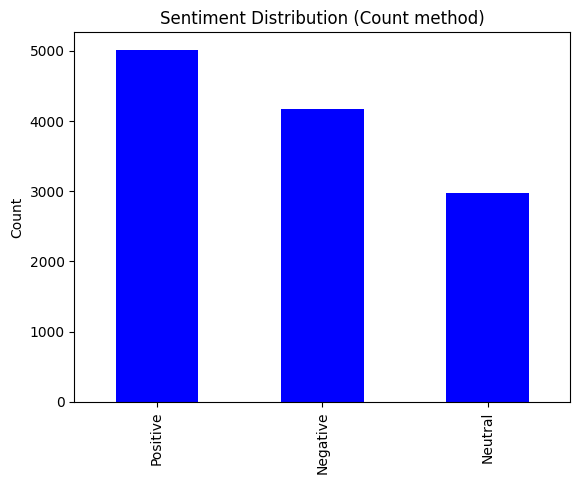

In [55]:
# Create a Pandas Series to count the occurrences of each class
sentiment_counts = pd.Series(sentiment_class).value_counts()

# Plot the class counts as a bar chart
sentiment_counts.plot(kind='bar', color='blue')

# Add labels and title
plt.xlabel('')
plt.ylabel('Count')
plt.title('Sentiment Distribution (Count method)')

# Display the plot
plt.show()

In [56]:
sentiment_counts

Positive    5012
Negative    4170
Neutral     2969
Name: count, dtype: int64

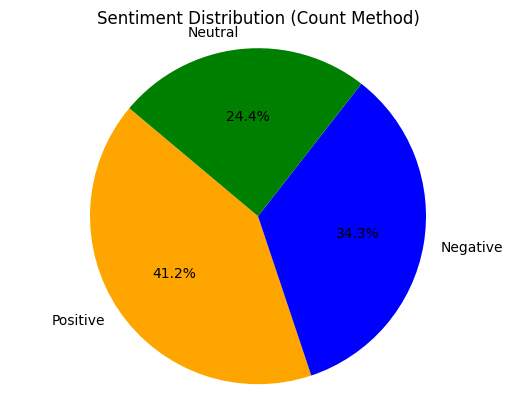

In [57]:
import matplotlib.pyplot as plt

# Sample data
labels = ['Positive', 'Negative', 'Neutral']
sizes = [5012, 4170, 2969]  # Sizes or proportions for each category
colors = ['orange', 'blue', 'green']  # Colors for each category

# Create a pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Sentiment Distribution (Count Method)')

# Display the chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

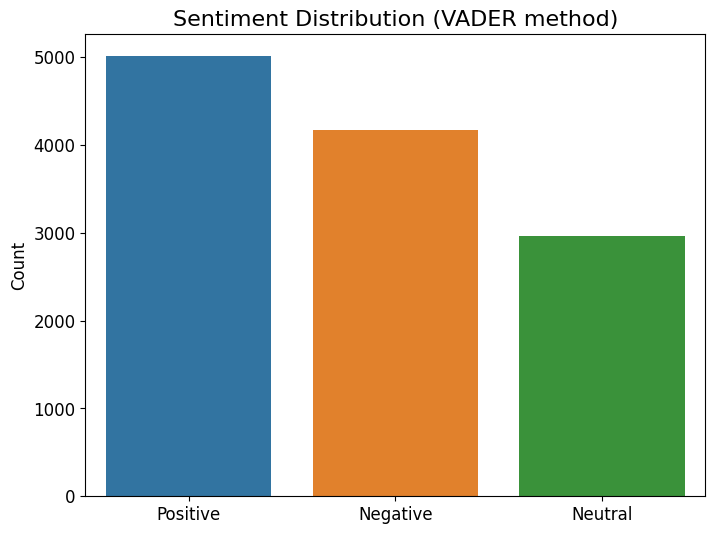

In [58]:
# Example DataFrame
vader_class = {
    'Category': ['Positive', 'Negative', 'Neutral'],
    'Value': [5012, 4170, 2969],
}

vader_class_df = pd.DataFrame(vader_class)


# Create a bar chart with the custom order using Seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.barplot(x='Category', y='Value', data=vader_class_df)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('')
plt.ylabel('Count', fontsize = 12)
plt.title('Sentiment Distribution (VADER method)', fontsize= 16)
plt.show()


## Result

### Find the overall sentiment using VADER method

In [59]:
VADER_df = pd.DataFrame(comments)

In [60]:
VADER_df

author                                               body  \
0              cfwang1337  What if your mouth is full of human meat? I'm ...   
1              IDinnaeKen  To be fair (and I’m not a vegan), reducing the...   
2      APotatoFlewAround_  As a meat eater the meat and dairy industry do...   
3              YeahWhyNot  I agree this is gatekeeping. No one should be ...   
4                    None  Not a vegan but the point is real. Meat produc...   
...                   ...                                                ...   
12146        Foritified_5  What a crock of BS. You're in a cult, kid. I r...   
12147              erincd      What? I didn't say anything about class 5 lol   
12148        Foritified_5  Right. What was I thinking. You just brought u...   
12149              erincd  I didn't say frequency\n\nYou cherry picked th...   
12150        Foritified_5  But if storms are increasing in intensity then...   

                      date  score  num_upvotes  num_downvotes  num_replies  \
0      2019-09-24T17:00:54   3340         3340              0           15   
1      2019-09-24T21:21:05    731          731              0            0   
2      2019-09-24T17:53:03    599          599              0            5   
3      2019-09-24T16:06:05   2287         2287              0           33   
4      2019-09-24T17:29:30   2518         2518              0           21   
...                    ...    ...          ...            ...          ...   
12146  2022-07-21T00:32:50      1            1              0            1   
12147  2022-07-21T00:34:25      1            1              0            1   
12148  2022-07-21T00:39:31      1            1              0            1   
12149  2022-07-21T00:41:21      1            1              0            1   
12150  2022-07-21T00:44:15      1            1              0            0   

       sentiment_score sentiment_class  
0               0.0000         Neutral  
1              -0.6361        Negative  
2               0.3182        Positive  
3               0.8957        Positive  
4               0.0772        Positive  
...                ...             ...  
12146           0.0790        Positive  
12147           0.4215        Positive  
12148          -0.0772        Negative  
12149          -0.2263        Negative  
12150           0.4215        Positive  

[12151 rows x 9 columns]

In [61]:
# Calculate the average sentiment compound score
average_sentiment = VADER_df["sentiment_score"].mean()

print(f"Average Sentiment Score: {average_sentiment:.4f}")
conclusion = add_sentiment_vader(average_sentiment)

print("Overall Sentiment using Reddit data:", conclusion)

Average Sentiment Score: 0.0350
Overall Sentiment using Reddit data: Neutral


### Find the top positive comment and negative comment using VADER method.

In [62]:
# Find the maximum and minimum values for a specific column
max_value = VADER_df['sentiment_score'].max()
min_value = VADER_df['sentiment_score'].min()
print(max_value, min_value)

0.9979 -0.9973


In [63]:
# Find the row with the highest sentiment score
highest_sentiment_row = VADER_df[VADER_df['sentiment_score'] == max_value]

# Extract author, body, date, and score from the highest sentiment row
highest_sentiment_author = highest_sentiment_row['author'].values[0]
highest_sentiment_body = highest_sentiment_row['body'].values[0]
highest_sentiment_date = highest_sentiment_row['date'].values[0]
highest_sentiment_score = highest_sentiment_row['score'].values[0]
highest_sentiment_replies = highest_sentiment_row['num_replies'].values[0]

# Print the details
print("Comment with Top Positive Sentiment Score:")
print("author:", highest_sentiment_author)
print("body:", highest_sentiment_body)
print("date:", highest_sentiment_date)
print("score:", highest_sentiment_score)
print('# of replies:', highest_sentiment_replies)
print('sentiment:', max_value)

Comment with Top Positive Sentiment Score:
author: nonbinarynpc
body: >Those restrictions are necessary otherwise we'd have a system  reminiscent of the late 19th century, large monopolies controlling  certain industries, no labor laws and uncontrollable exploitation. 

I'm about to say a ton of stuff because you listed some extremely nuanced topics. If you want to choose your favorite to discuss rather than respond to everything I have to say, I'd be happy with that.

The issues you've listed are mostly caused by government, the times as they were, or new technology. Monopolies are mostly government entities, and even aside from the monopolistic government systems themselves, actual natural monopolies are incredibly rare. It's mostly like I said: We created rules to regulate business, and business buys the rules, giving them a huge leg up on the competition. Standard Oil was an actual natural monopoly, and they had their bad points and their good points, but reducing the price of kero

In [64]:
# Find the row with the lowest sentiment score
lowest_sentiment_row = VADER_df[VADER_df['sentiment_score'] == min_value]

# Extract author, body, date, score, num_replies, and sentiment from the lowest sentiment row
lowest_sentiment_author = lowest_sentiment_row['author'].values[0]
lowest_sentiment_body = lowest_sentiment_row['body'].values[0]
lowest_sentiment_date = lowest_sentiment_row['date'].values[0]
lowest_sentiment_score = lowest_sentiment_row['score'].values[0]
lowest_sentiment_num_replies = lowest_sentiment_row['num_replies'].values[0]
lowest_sentiment_sentiment = lowest_sentiment_row['sentiment_class'].values[0]

# Print the details
print("Author with Lowest Sentiment Score:")
print("Author:", lowest_sentiment_author)
print("Body:", lowest_sentiment_body)
print("Date:", lowest_sentiment_date)
print("Score:", lowest_sentiment_score)
print("Number of Replies:", lowest_sentiment_num_replies)
print('sentiment:', min_value)


Author with Lowest Sentiment Score:
Author: sergeybrin46
Body: I'm not calling it terrorism, I made no commentary on it, just copied the definition and highlighted the portions that applied.

But now I'll go ahead and evaluate it. The element of violence is clearly not required, it says violence and intimidation. It doesn't say violence or intimidation, because it can be both, but the "and" doesn't mean that both parts are required. Here, I'll give another example. Otherwise it would say "the unlawful use of both violence and intimidation." Here's another example:

>a person having a strong desire to assume the physical characteristics and gender role of a different sex.

The above is the definition for transsexual, and while there's an "and" it doesn't mean that someone is not trans just because they don't BOTH have the physical characteristics AND and the gender role. 

I'll also provide another example, but in a different way.

If a group of hackers target US infrastructure, and dam